# BaristaSeq

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import *
from sklearn.metrics.cluster import adjusted_rand_score

In [3]:
import BINARY

In [4]:
import pysodb
sodb = pysodb.SODB()

In [5]:
# Define names of the dataset_name and experiment_name
dataset_name = 'Sun2021Integrating'
experiment_name = 'Slice_2'
# Load a specific experiment
# It takes two arguments: the name of the dataset and the name of the experiment to load.
# Two arguments are available at https://gene.ai.tencent.com/SpatialOmics/.
adata_raw = sodb.load_experiment(dataset_name,experiment_name)

load experiment[Slice_2] in dataset[Sun2021Integrating]


In [6]:
adata_raw

AnnData object with n_obs × n_vars = 4491 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'leiden'
    uns: 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [7]:
adata_raw = adata_raw[(adata_raw.obs['layer']!='VISp') & (adata_raw.obs['layer']!='outside_VISp')]
adata_raw

View of AnnData object with n_obs × n_vars = 2042 × 79
    obs: 'Slice', 'x', 'y', 'Dist to pia', 'Dist to bottom', 'Angle', 'unused-1', 'unused-2', 'x_um', 'y_um', 'depth_um', 'layer', 'leiden'
    uns: 'leiden', 'leiden_colors', 'log1p', 'moranI', 'neighbors', 'pca', 'spatial_neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [8]:
adata = BINARY.clean_adata(adata_raw, save_obs=['layer'])
adata

AnnData object with n_obs × n_vars = 2042 × 79
    obs: 'layer'
    obsm: 'spatial'

In [9]:
adata.var_names_make_unique()

In [10]:
adata = BINARY.Count2Binary(adata)

In [11]:
BINARY.Construct_Spatial_Graph(adata, use_method='KNN', cutoff=18)

------Constructing spatial graph...------
The graph contains 36756 edges, 2042 cells.
18.0000 neighbors per cell on average.


In [12]:
adata = BINARY.train_BINARY(adata, pos_weight = 10, device= 'cuda:0')

Size of Input:  (2042, 79)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 179.07it/s]


In [13]:
sc.pp.neighbors(adata, use_rep='BINARY')
sc.tl.umap(adata)

In [14]:
adata = BINARY.mclust_R(adata, used_obsm='BINARY', num_cluster=6)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.0
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


In [16]:
# Compute the adjusted rand index (ARI) between the 'mclust' and the 'Ground Truth'. 
obs_df = adata.obs.dropna()
ARI = adjusted_rand_score(obs_df['mclust'], obs_df['layer'])
print('ARI = %.2f' %ARI)

ARI = 0.80


In [17]:
from sklearn.metrics import *
NMI = normalized_mutual_info_score(obs_df['mclust'], obs_df['layer'])
print('NMI = %.2f' %NMI)

NMI = 0.82


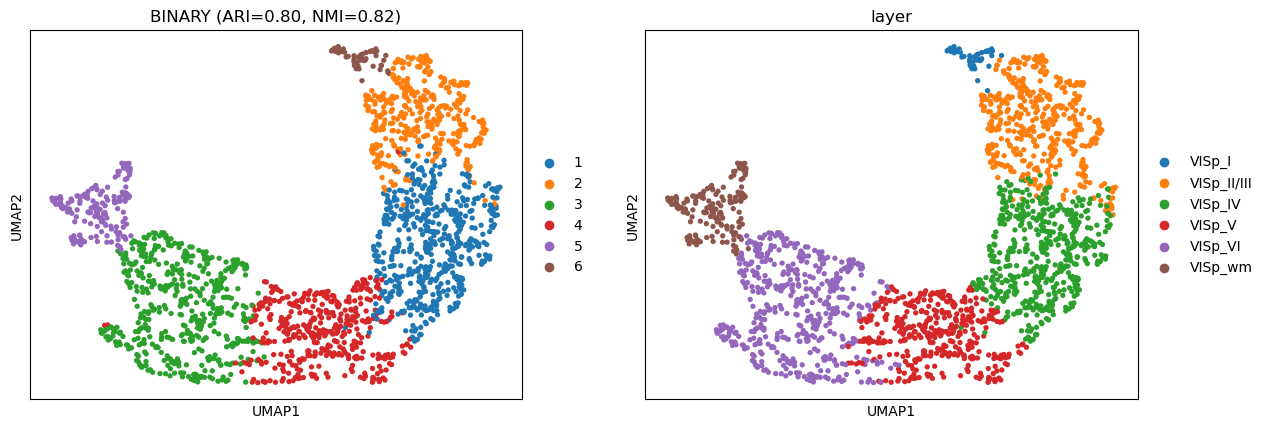

In [18]:
sc.pl.umap(adata, color=["mclust", 'layer'], title=['BINARY (ARI=%.2f, NMI=%.2f)'%(ARI, NMI), 'layer'])

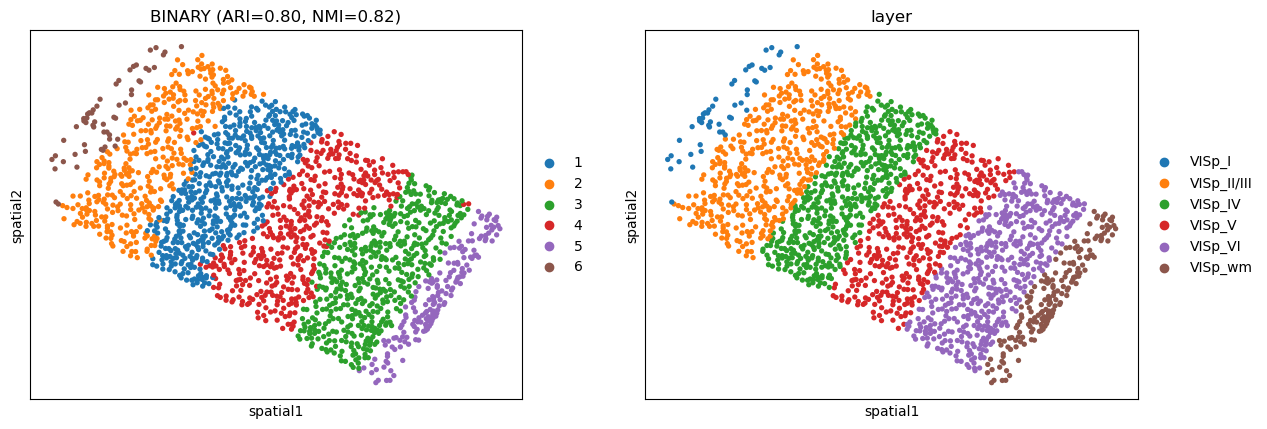

In [19]:
sc.pl.embedding(adata, basis='spatial', color=["mclust", 'layer'], title=['BINARY (ARI=%.2f, NMI=%.2f)'%(ARI, NMI), 'layer'])

In [20]:
new_type = BINARY.Refine_label(adata, radius=30, key='mclust')
adata.obs['domain'] = new_type 

In [21]:
obs_df = adata.obs.dropna()
refine_ARI = adjusted_rand_score(obs_df['domain'], obs_df['layer'])
print('Refine ARI = %.2f' %refine_ARI)

Refine ARI = 0.81


In [22]:
refine_NMI = normalized_mutual_info_score(obs_df['domain'], obs_df['layer'])
print('NMI = %.2f' %refine_NMI)

NMI = 0.82


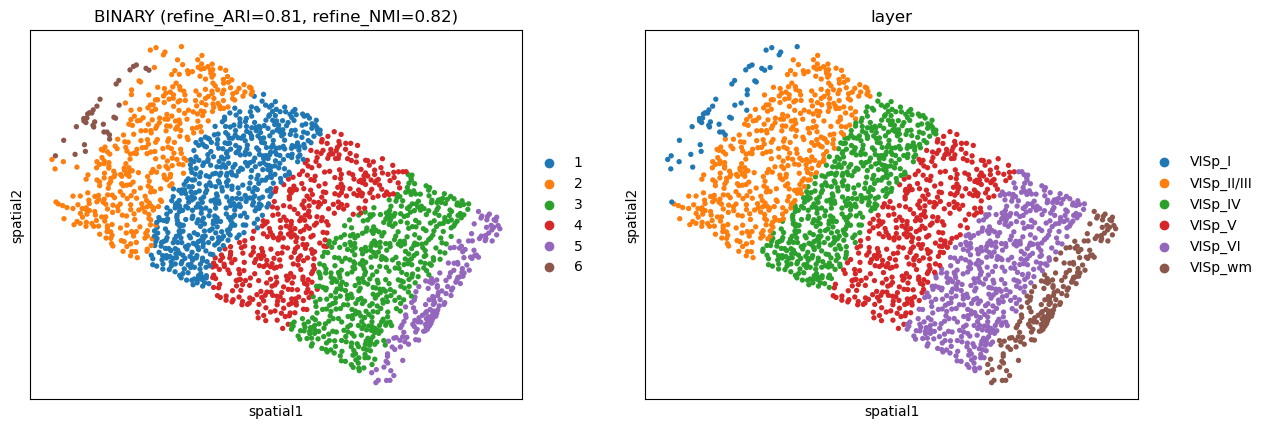

In [23]:
sc.pl.embedding(adata, basis='spatial', color=['domain', "layer"], title=['BINARY (refine_ARI=%.2f, refine_NMI=%.2f)'%(refine_ARI, refine_NMI), "layer"])